In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./ml.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from utils_common import dlc, load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [7]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


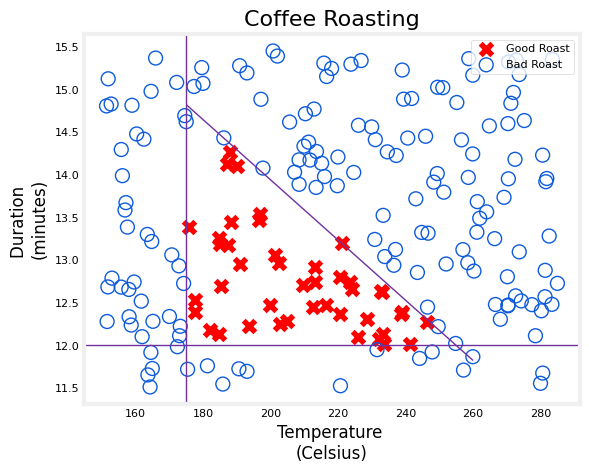

In [8]:
plt_roast(X,Y)

- create a "Normalization Layer". Note, as applied here, this is not a layer in the NN.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.  

In [9]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


2023-12-24 20:21:44.243756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-24 20:21:44.244097: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


In [11]:
# model
tf.random.set_seed(1234) # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. 

The `model.summary()` provides a description of the network:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [14]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 1.01  1.01 -0.93]
 [-0.92 -0.55  0.56]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.66]
 [ 1.2 ]
 [-0.61]] 
b2(1,): [0.]


In [15]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 5s 733us/step - loss: 0.1835
Epoch 2/10
6250/6250 [==============================] - 4s 672us/step - loss: 0.1217
Epoch 3/10
6250/6250 [==============================] - 4s 613us/step - loss: 0.0611
Epoch 4/10
6250/6250 [==============================] - 4s 694us/step - loss: 0.0191
Epoch 5/10
6250/6250 [==============================] - 4s 667us/step - loss: 0.0123
Epoch 6/10
6250/6250 [==============================] - 4s 684us/step - loss: 0.0088
Epoch 7/10
6250/6250 [==============================] - 4s 626us/step - loss: 0.0064
Epoch 8/10
6250/6250 [==============================] - 4s 629us/step - loss: 0.0047
Epoch 9/10
6250/6250 [==============================] - 4s 622us/step - loss: 0.0034
Epoch 10/10
6250/6250 [==============================] - 4s 698us/step - loss: 0.0026


In [16]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-0.02 12.83 14.33]
 [-8.89  0.33 11.9 ]] 
b1: [-11.16  13.38   1.73]
W2:
 [[-45.09]
 [ 38.19]
 [-43.24]] 
b2: [-12.34]


In [17]:
# input data to the model
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 42ms/step
predictions = 
 [[9.88e-01]
 [2.79e-08]]


In [18]:
# apply a threshold to convert probabilities to a decision
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


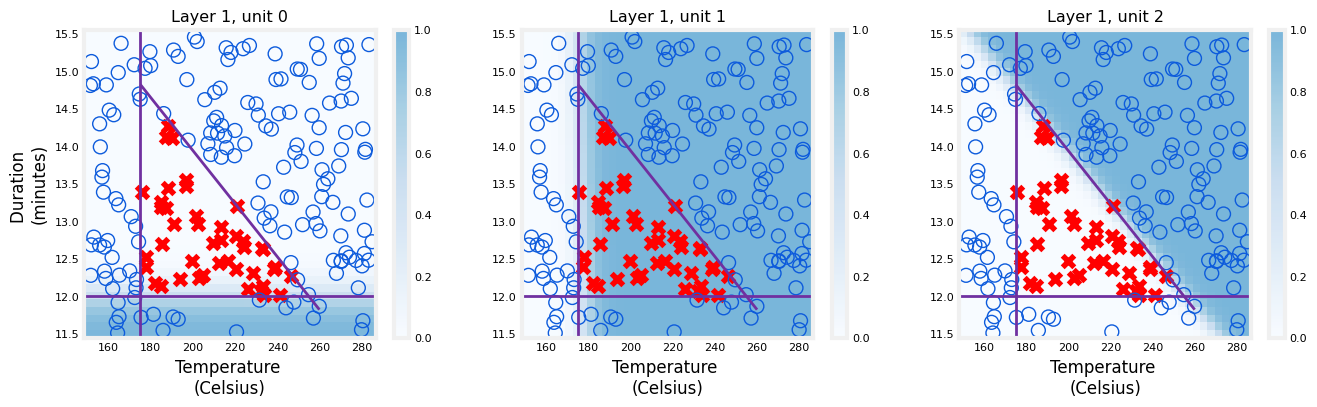

In [19]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

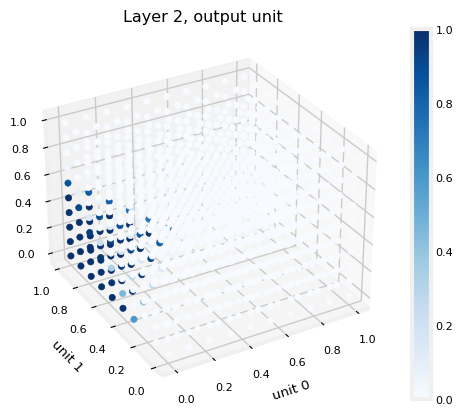

In [20]:
plt_output_unit(W2,b2)

7/7 [==============================] - 0s 805us/step


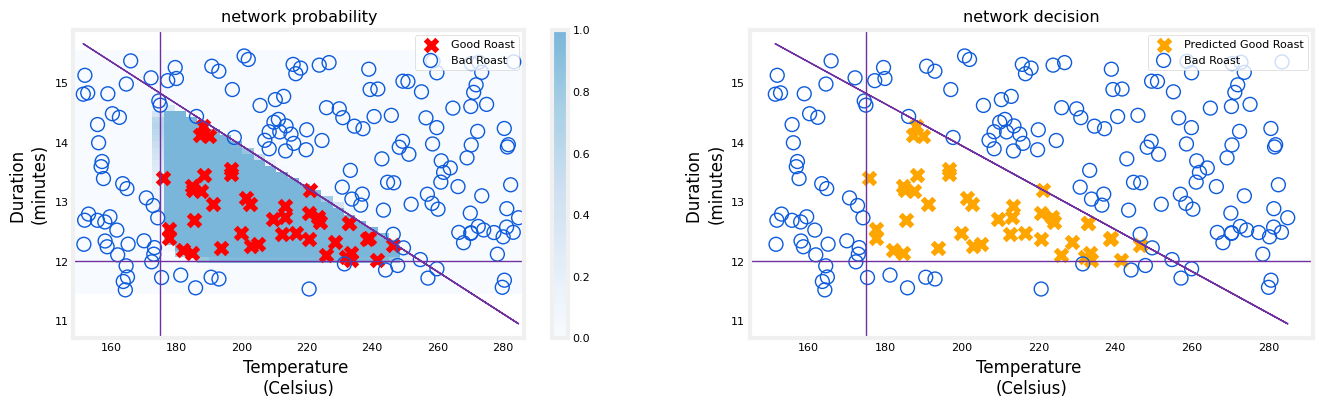

In [21]:
netf= lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)